In [1]:
import os, csv, subprocess
from pathlib import Path

#Reading data
import geopandas as gpd
import pickle
import pandas as pd

#Calculations
import numpy as np
import scipy.stats as stats
from scipy import optimize
from scipy.stats import linregress

#Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

## This notebook reproduces Figure 2 and Figure 3 in the manuscript. 

### Functions needed to make the plots:

In [2]:
def cumul_prob(data):
    data = np.sort(data)
    return np.array([(data[i] < data).sum() for i in range(len(data))])

def normed_CPD(data):
    data = np.sort(data)
    prob = [(data[i] < data).sum() for i in range(len(data))]
    return prob / max(prob)

### Prepare Figure 2

### Import the data:

In [11]:
allData = pd.read_csv('Ngozumpa-data/Ngozumpa-depressions-2019.csv')
print("Column Headers: ", list(allData))

Column Headers:  ['fid', 'area', 'perimeter', 'depth']


### Remove depressions smaller than 10 m$^2$:

In [12]:
data = allData[allData['area'] >= 10]

,fid,area,perimeter,depth
0,1,21,40,0.149902
1,2,10,22,0.244629
2,3,56,56,0.692871
3,4,193,114,0.963379
4,5,672,216,4.694336
...,...,...,...,...
31319,31320,211,130,1.146973
31320,31321,181,76,3.335449
31321,31322,461,168,2.797363
31322,31323,282,146,2.133789


### Create the figure

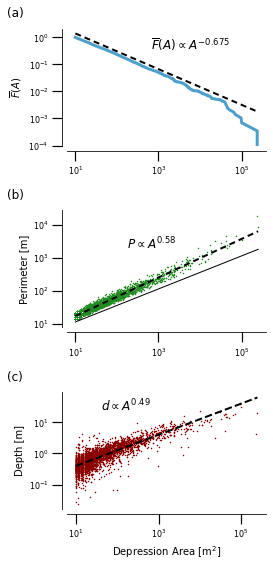

In [59]:
areas = data['area']
perimeters = data['perimeter']
depths = data['depth']

fig, ax = plt.subplots(3,1, figsize = (4,8))

#Calculate probability densities
alpha = 1.66
amin = 10
x = np.linspace(min(areas), max(areas), 5000)
cpd = (amin / x)**(alpha - 1)
dataCPD = normed_CPD(data['area'])

#Plot probability densities #dodgerblue
ax[0].loglog(np.sort(areas), dataCPD, linewidth = 3, color = '#4d9fcc')#, markerfacecolor = 'none')
ax[0].loglog(x, 1.4*cpd, linestyle = '--', dashes = (3,2), linewidth = 2, label = '$\\overline{F}(A) \propto A^{-0.675} $', color = 'k')
ax[0].legend(loc = (.35, .75), fontsize = 12, framealpha = 1, handlelength = 0, frameon = False)
ax[0].set_xlim([10**0.8, 10**5.6])
ax[0].set_ylabel('$\\overline{F}(A)$', fontsize = 10)
ax[0].get_xaxis().set_ticks([10**1, 10**3, 10**5])
ax[0].get_yaxis().set_ticks([10**-4, 10**-3, 10**-2, 10**-1, 10**0])
ax[0].tick_params('both', length = 10, width = 1.2, which = 'major', labelsize = 8)
ax[0].tick_params('both', length = 0, width = 1, which = 'minor')
ax[0].annotate('(a)', xy = (-.3,1.1), xycoords = 'axes fraction', fontsize = 12)

#Calculate the fractal perimeter dimension
sqAreas = np.sqrt(areas)
D, b, r, p, se = linregress(np.log10(np.sqrt(areas)), np.log10(perimeters))

#Plot fractal dimensions #forestgreen
ax[1].loglog(areas, perimeters, 'o', markersize = 1.5, markerfacecolor = 'forestgreen', markeredgecolor = 'none')
ax[1].loglog(x, 10**b*x**(D/2), linestyle = '--', dashes = (3,2), linewidth = 2, label = '$P \propto A^{0.58}$', color = 'k')
ax[1].loglog(x, 3.6*x**0.5,  linewidth = 1, color = 'k')
ax[1].legend(loc = (.23, .6), fontsize = 12, handlelength = 0, framealpha = 1, frameon = False)
ax[1].set_xlim([10**0.8, 10**5.6])
ax[1].set_ylabel('Perimeter [m]', fontsize = 10)
ax[1].get_xaxis().set_ticks([10**1, 10**3, 10**5])
ax[1].tick_params('both', length = 10, width = 1.2, which = 'major', labelsize = 8)
ax[1].tick_params('both', length = 0, width = 1, which = 'minor')
ax[1].annotate('(b)', xy = (-0.3,1.1), xycoords = 'axes fraction', fontsize = 12)

#Calculate depth-area scaling exponent
d, yint, rval, pval, se = linregress(np.log10(areas), np.log10(depths))

#Plot depth-area scaling
ax[2].loglog(areas, depths, 'o', markersize = 1.5, markerfacecolor = 'darkred', markeredgecolor = 'none')
ax[2].loglog(x, 10**yint*x**d, '--', c = 'k', linewidth = 2, label = '$d \propto A^{0.49}$') 
ax[2].get_xaxis().set_ticks([10**1,10**3,10**5])
ax[2].set_ylabel('Depth [m]', fontsize = 10)
ax[2].tick_params(labelsize = 8)
ax[2].tick_params('both', length = 10, width = 1.2, which = 'major')
ax[2].legend(loc = (0.1,0.77), handlelength = 0, fontsize = 12, frameon = False)
ax[2].set_xlabel('Depression Area [m$^2$]', fontsize = 10)
ax[2].annotate('(c)', xy = (-.3,1.1), xycoords = 'axes fraction', fontsize = 12)

plt.minorticks_off()
sns.despine(offset = 5)
fig.subplots_adjust(hspace = 0.15, wspace = 0.25)
plt.tight_layout()

fig.set_facecolor('white')

plt.savefig('figure-2_GRL.png', dpi = 600)
plt.show()

## Prepare Figure 3

### Import the data

In [3]:
n = "500" #Write the initial number of depressions in each model space as string (500, 750, 1000, or 1250)
            #Figure shown in the paper n = 500

pickle_file = Path("model-data/pickle-files/1-25_m_500_sim-1_time=10.pkl")
    
#Simulations with mergers
d1 = "model-data/csv-files/0-5_m_output/csv-files/" + n

areasList1 = []

for f in os.listdir(d1):
    df = pd.read_csv(os.path.join(d1, f))
    last_step = df.iloc[:,-1]
    areasList1.append(last_step.iloc[:])
    
areasList1 = np.array(areasList1)
areasList1 = areasList1[~np.isnan(areasList1)]

d2 = "model-data/csv-files/1_m_output/csv-files/" + n

areasList2 = []

for f in os.listdir(d2):
    df = pd.read_csv(os.path.join(d2, f))
    last_step = df.iloc[:,-1]
    areasList2.append(last_step.iloc[:])
    
areasList2 = np.array(areasList2)
areasList2 = areasList2[~np.isnan(areasList2)]

d3 = "model-data/csv-files/1-25_m_output/csv-files/" + n

areasList3 = []

for f in os.listdir(d3):
    df = pd.read_csv(os.path.join(d3, f))
    last_step = df.iloc[:,-1]
    areasList3.append(last_step.iloc[:])
    
areasList3 = np.array(areasList3)
areasList3 = areasList3[~np.isnan(areasList3)]

d4 = "model-data/csv-files/1-5_m_output/csv-files/" + n

areasList4 = []

for f in os.listdir(d4):
    df = pd.read_csv(os.path.join(d4, f))
    last_step = df.iloc[:,-1]
    areasList4.append(last_step.iloc[:])
    
areasList4 = np.array(areasList4)
areasList4 = areasList4[~np.isnan(areasList4)]


#Simulations without mergers
d5 = "model-data/csv-files/0-5_nm_output/csv-files/" + n

areasList5 = []

for f in os.listdir(d5):
    df = pd.read_csv(os.path.join(d5, f))
    last_step = df.iloc[:,-1]
    areasList5.append(last_step.iloc[:])
    
areasList5 = np.array(areasList5)
areasList5 = areasList5[~np.isnan(areasList5)]

d6 = "model-data/csv-files/1_nm_output/csv-files/" + n

areasList6 = []

for f in os.listdir(d6):
    df = pd.read_csv(os.path.join(d6, f))
    last_step = df.iloc[:,-1]
    areasList6.append(last_step.iloc[:])
    
areasList6 = np.array(areasList6)
areasList6 = areasList6[~np.isnan(areasList6)]

d7 = "model-data/csv-files/1-25_nm_output/csv-files/" + n

areasList7 = []

for f in os.listdir(d7):
    df = pd.read_csv(os.path.join(d7, f))
    last_step = df.iloc[:,-1]
    areasList7.append(last_step.iloc[:])
    
areasList7 = np.array(areasList7)
areasList7 = areasList7[~np.isnan(areasList7)]

d8 = "model-data/csv-files/1-5_nm_output/csv-files/" + n

areasList8 = []

for f in os.listdir(d8):
    df = pd.read_csv(os.path.join(d8, f))
    last_step = df.iloc[:,-1]
    areasList8.append(last_step.iloc[:])
    
areasList8 = np.array(areasList8)
areasList8 = areasList8[~np.isnan(areasList8)]

### Calculate the CCDFs for the simulation data

In [4]:
dataCPD1 = normed_CPD(areasList1)
dataCPD2 = normed_CPD(areasList2)
dataCPD3 = normed_CPD(areasList3)
dataCPD4 = normed_CPD(areasList4)

dataCPD5 = normed_CPD(areasList5)
dataCPD6 = normed_CPD(areasList6)
dataCPD7 = normed_CPD(areasList7)
dataCPD8 = normed_CPD(areasList8)

### Create the figure

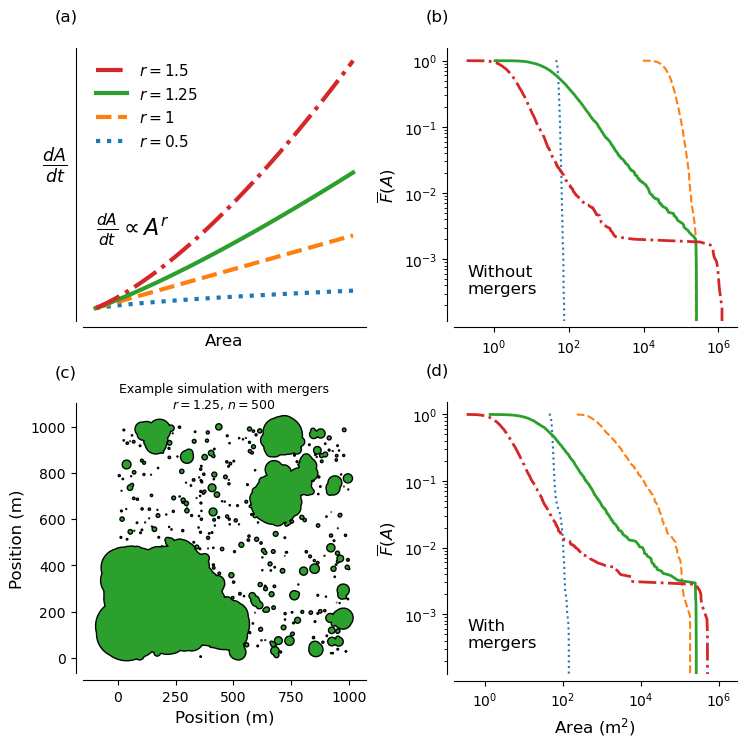

In [11]:
fig, ax = plt.subplots(2,2, figsize = (7.5, 7.5))

ax[0,1].loglog(np.sort(areasList5), dataCPD5, linestyle = 'dotted')
ax[0,1].loglog(np.sort(areasList6), dataCPD6, linestyle = 'dashed')
ax[0,1].loglog(np.sort(areasList7), dataCPD7, linewidth = 2, linestyle = 'solid')
ax[0,1].loglog(np.sort(areasList8), dataCPD8, linewidth = 2, linestyle = 'dashdot')
#ax[0,1].set_xlabel('Area (m$^2$)', fontsize = 12)
ax[0,1].set_ylabel('$\overline{F}(A)$', fontsize = 12)
ax[0,1].set_xticks([10**0, 10**2, 10**4, 10**6])
ax[0,1].tick_params(axis = 'both', which = 'both', labelsize = 10)
ax[0,1].annotate(text = 'Without\nmergers', xy = (0.05,0.1), xytext = (0.05,0.1), xycoords = 'axes fraction', fontsize = 12)
ax[0,1].annotate(text = '(b)', xy = (-0.1,1.1), xytext = (-0.1, 1.1), xycoords = 'axes fraction', fontsize = 12)

ax[1,1].loglog(np.sort(areasList1), dataCPD1, linestyle = 'dotted')
ax[1,1].loglog(np.sort(areasList2), dataCPD2, linestyle = 'dashed')
ax[1,1].loglog(np.sort(areasList3), dataCPD3, linewidth = 2, linestyle = 'solid')
ax[1,1].loglog(np.sort(areasList4), dataCPD4, linewidth = 2, linestyle = 'dashdot')
ax[1,1].set_xlabel('Area (m$^2$)',fontsize = 12)
ax[1,1].set_ylabel('$\overline{F}(A)$', fontsize = 12)
ax[1,1].set_xticks([10**0, 10**2, 10**4, 10**6])
ax[1,1].annotate(text = 'With\nmergers', xy = (0.05,0.1), xytext = (0.05,0.1), xycoords = 'axes fraction', fontsize = 12)
ax[1,1].annotate(text = '(d)', xy = (-0.1,1.1), xytext = (-0.1, 1.1), xycoords = 'axes fraction', fontsize = 12)

A = np.linspace(1, 10, 100)

ax[0,0].plot(A, A**0.5, linewidth = 3, label = '$r=0.5$', linestyle = 'dotted')
ax[0,0].plot(A, A**1, linewidth = 3, label = '$r=1$', linestyle = 'dashed')
ax[0,0].plot(A, A**1.25, linewidth = 3, label = '$r=1.25$', linestyle = 'solid')
ax[0,0].plot(A, A**1.5, linewidth = 3, label = '$r=1.5$', linestyle = 'dashdot')
ax[0,0].tick_params(axis = 'both', which = 'both', bottom = False, left = False, labelbottom = False, labelleft = False)
ax[0,0].set_xlabel('Area', fontsize = 12)
ax[0,0].set_ylabel('$\\frac{dA}{dt}$', rotation = 0, labelpad = 15, fontsize = 18)
ax[0,0].annotate(text = '$\\frac{dA}{dt} \propto A^{r}$', xy = (1,13), xytext = (1,10), xycoords = 'data', fontsize = 16)
ax[0,0].annotate(text = '(a)', xy = (-0.1,1.1), xytext = (-0.1, 1.1), xycoords = 'axes fraction', fontsize = 12)
handles, labels = ax[0,0].get_legend_handles_labels()
ax[0,0].legend(handles[::-1], labels[::-1], fontsize = 11, frameon = False)

file = open(pickle_file, 'rb')
model = pickle.load(file)
example = gpd.GeoSeries(model)

example.plot(ax = ax[1,0], edgecolor = 'k', color = 'C2')
ax[1,0].set_xlabel('Position (m)', fontsize = 12)
ax[1,0].set_ylabel('Position (m)', fontsize = 12)
ax[1,0].set_title('Example simulation with mergers\n$r=1.25$, $n=500$', fontsize = 9, y = 0.95)
ax[1,0].annotate(text = '(c)', xy = (-0.1,1.1), xytext = (-0.1, 1.1), xycoords = 'axes fraction', fontsize = 12)

plt.tight_layout()
sns.despine(offset = 5)
fig.set_facecolor('white')
plt.savefig('figure-3_GRL.png', dpi = 300)
plt.show()